In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy import stats

In [ ]:
# Define clonotype field names
# - V gene, J gene, CDR3 length
clonotype_filter = ["V-GENE", "J-GENE", "CDR3_len"]
def clonotype_format(x): return "{}.{}.{}".format(*x)

In [23]:
# Get list of sample clonotypes
summary_files = [
    f for f in 
    glob.iglob(
        "/nfs/users/nfs_b/bb9/workspace/rotation2/team115_lustre/data/existing_bcr_data/MalariaSamplesBen/**/*_Summary.txt", 
        recursive=True, 
    )
]

# Extract sample day and number from filename
p = re.compile(r'Day(\d+)/LEA_S(\d+)_Summary.txt')
days = [p.search(f).group(1) for f in summary_files]
sample_nums = [p.search(f).group(2) for f in summary_files]

# Read in all summary files
summary_df = pd.concat(
    (pd.read_table(f, header=0, usecols=list(range(0,30))) for f in summary_files),
    keys=zip(days, sample_nums),
    names=["day", "sample_num"]
)
summary_df.index.names = pd.core.base.FrozenList(['day', 'sample_num', 'seq_i'])

# Count unique BCRs per sample
# print(summary_df.groupby(level="sample_num").apply(lambda x: x.shape))

# List possible Functionalities
# print(summary_df["Functionality"].unique())
# Filter out unproductive and "No results"
summary_df = summary_df[summary_df["Functionality"].isin(['productive', 'productive (see comment)'])]

# Count unique BCRs per sample after filter
# print(summary_df.groupby(level="sample_num").apply(lambda x: x.shape))

# Convert row indices into columns
summary_df = summary_df.reset_index(level=summary_df.index.names)
del summary_df["seq_i"]

# Get V J gene assignments by taking the first assignment, collapsing alleles.
summary_df["V-GENE"] = [x.split(", or ")[0].split("*")[0].replace("Homsap ", "") for x in summary_df["V-GENE and allele"]]
summary_df["J-GENE"] = [x.split(", or ")[0].split("*")[0].replace("Homsap ", "") for x in summary_df["J-GENE and allele"]]

summary_df["CDR3_len"] = summary_df["CDR3-IMGT length"]
summary_df[["day", "sample_num"]] = summary_df[["day", "sample_num"]].apply(pd.to_numeric)

# Get clonotypes for known mAbs
mAb_df = pd.read_csv("/nfs/users/nfs_b/bb9/workspace/rotation2/team115_lustre/data/existing_bcr_data/MalariaSamplesBen/IgBlast_bnAbs.csv")
mAb_df["V-GENE"] = [x.split(",")[0].split("*")[0] for x in mAb_df["V gene"]]
mAb_df["J-GENE"] = [x.split(",")[0].split("*")[0] for x in mAb_df["J gene"]]
mAb_df["CDR3_len"] = mAb_df["CDR3 amino acid seq"].map(len)
mAb_df["clonotype"] = mAb_df[clonotype_filter].apply(clonotype_format, axis=1)

# Get clonotypes for existing data
summary_df["clonotype"] = summary_df[clonotype_filter].apply(clonotype_format, axis=1)

# Read in sample information
sample_info_df = pd.read_excel("/nfs/users/nfs_b/bb9/workspace/rotation2/team115_lustre/data/existing_bcr_data/MalariaSamplesBen/Malaria_Samples_SeqInfo.xlsx")
sample_info_df["patient_code"] = sample_info_df["patient_code"].astype("category")

# Calculate normalisation factor per sample.
# If a sample has an above average number of reads, 
# the contribution to normalised clonotype abundance by that sample should be lower.
sample_info_df["norm_factor"] = np.mean(sample_info_df["Reads, count"]) / sample_info_df["Reads, count"]

# Merge in patient number and cell type
summary_df = pd.merge(summary_df, sample_info_df[["Tag Index", "patient_code", "cell_type", "norm_factor"]], 
         how="left", left_on="sample_num", right_on="Tag Index")

# Merge in known mAb name
summary_df = pd.merge(summary_df, mAb_df[["Ab.Name", "clonotype"]], 
         how="left", on="clonotype")
summary_df

,day,sample_num,Sequence number,Sequence ID,digest,Functionality,V-GENE and allele,V-REGION score,V-REGION identity %,V-REGION identity nt,...,Sequence,V-GENE,J-GENE,CDR3_len,clonotype,Tag Index,patient_code,cell_type,norm_factor,Ab.Name
0,0,16,1,MS7_20154111092026411880__0_0_0_0_0_1_0_0_0_0_...,IGHG1,productive,"Homsap IGHV3-23*01 F, or Homsap IGHV3-23*04 F ...",845.0,92.39,182/197 nt,...,cctatgccatgacctgggtccgccaggctccagggaagggtctgga...,IGHV3-23,IGHJ3,23,IGHV3-23.IGHJ3.23,16,2207,plasma,1.188326,NaN
1,0,16,2,MS7_20154111042072910943__1_0_0_0_0_0_0_0_0_0_...,IGHA1,productive,Homsap IGHV1-18*01 F,852.0,93.78,181/193 nt,...,tggtgtcagctgggtgcgacaggcccctggacaagggcttgagtgg...,IGHV1-18,IGHJ4,14,IGHV1-18.IGHJ4.14,16,2207,plasma,1.188326,NaN
2,0,16,3,MS7_2015411101802120649__0_0_0_0_0_0_1_0_0_0_0...,IGHG2,productive,Homsap IGHV1-2*02 F,960.0,100.00,193/193 nt,...,ctatatgcactgggtgcgacaggcccctggacaagggcttgagtgg...,IGHV1-2,IGHJ5,13,IGHV1-2.IGHJ5.13,16,2207,plasma,1.188326,NaN
3,0,16,4,MS7_20154111121956212740__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV2-70*01 F,1177.0,97.19,242/249 nt,...,acacagaccctcacactgacctgcaccttctctgggttctcactca...,IGHV2-70,IGHJ6,20,IGHV2-70.IGHJ6.20,16,2207,plasma,1.188326,NaN
4,0,16,5,MS7_2015411107256174723__0_0_0_0_0_1_0_0_0_0_0...,IGHG1,productive,Homsap IGHV4-30-4*01 F,828.0,85.40,193/226 nt,...,cagtgtctctggtgactacatcagccaaggtgattactactggact...,IGHV4-30-4,IGHJ4,18,IGHV4-30-4.IGHJ4.18,16,2207,plasma,1.188326,NaN
5,0,16,6,MS7_20154111102474611152__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV3-49*04 F,911.0,94.58,192/203 nt,...,attatgctatgagttgggtccgccaggctccagggaaggggctgga...,IGHV3-49,IGHJ3,15,IGHV3-49.IGHJ3.15,16,2207,plasma,1.188326,NaN
6,0,16,7,MS7_201541110596759208__0_0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,Homsap IGHV3-48*03 F,917.0,96.45,190/197 nt,...,gttatgaaatgaactgggtccgccaggctccagggaaggggctgga...,IGHV3-48,IGHJ4,14,IGHV3-48.IGHJ4.14,16,2207,plasma,1.188326,NaN
7,0,16,8,MS7_2015412117448121042__0_0_0_0_0_1_0_0_0_0_0...,IGHG1,productive,"Homsap IGHV3-23*01 F, or Homsap IGHV3-23*04 F ...",854.0,92.89,183/197 nt,...,cttatgccatggcctgggtccgccaggctccagggaagggtctgga...,IGHV3-23,IGHJ3,23,IGHV3-23.IGHJ3.23,16,2207,plasma,1.188326,NaN
8,0,16,9,MS7_20154111191727013216__0_1_0_0_0_0_0_0_0_0_...,IGHA2,productive,"Homsap IGHV4-4*02 F, or Homsap IGHV4-4*03 F or...",930.0,91.03,203/223 nt,...,cgctgtctctggtggctccctcagcagtagtgagtggataagttgg...,IGHV4-4,IGHJ5,10,IGHV4-4.IGHJ5.10,16,2207,plasma,1.188326,NaN
9,0,16,10,MS7_201541211749108038__1_0_0_0_0_0_0_0_0_0_0_...,IGHA1,productive,"Homsap IGHV1-2*02 F, or Homsap IGHV1-2*05 F",861.0,94.30,182/193 nt,...,ctatattcactgcgtgcgacaggcccctggacaagggcttgagtgg...,IGHV1-2,IGHJ4,14,IGHV1-2.IGHJ4.14,16,2207,plasma,1.188326,NaN



# Questions to ask

How is immunity to the vaccine candidate achieved?

- due to antibodies... which we detect via expansion and mutational frequency


- V(D)J gene frequencies, Ig isotype usage, and BCR clone size, stratified by timepoint and patient
- Look for expansion of clonotypes in day 63 and 140 vs. day 0
- Compare expanded clonotypes to known Ab sequences
- Look for differences between patients at day 0
- Calculate mutational frequencies of clonotypes

Plots:

- Area/bar/parallel coords chart showing expansion of clonotypes (known V genes?) over time

## Comparison across individuals at pre-prime (day 0)

RH5 and Duffy samples

- Distribution of clonotypes between individuals
- How diverse is the repertoire? Gini index?
- Run comparison across cell types

## Clonotypes at early post prime (day 28)

Look for:

- clonotype freq
- isotype distribution
- mutational freq (1-% identity) vs. IMGT V gene reference
    - linear regression of BCR mutational frequency against clonotype V gene status
    - mutational freq stratified by isotype
    
In the compartments:

- For memory cells vs day 0
- For plasmablasts vs naive repertoire (IgD/IgM unmutated sequences taken from PBMC samples at Day 0)

- Are expanded/mutated clonotypes the same as the
    - known anti-RH5 Ab sequences
    - ones observed in AMA1 and Duffy trials
    - ones observed in influenza and other infection challenge

## Clonotypes at early post boost (day 63)

Look for:

- clonotype freq
- isotype distribution
- mutational freq (1-% identity) vs. IMGT V gene reference
    - linear regression of BCR mutational frequency against clonotype V gene status
    - mutational freq stratified by isotype
    
In the compartments:

- For memory cells vs day 0 and day 28
- For plasmablasts vs plasmoblasts at day 0 and day 28
    - activation of same clonotypes during prime and boost?
- For plasmablasts vs naive repertoire at day 0 and day 28
- For plasmablasts vs memory repertoire at day 0 and day 28
    - recall of memory cells generated at the prime?

- clonotype overlap between 

## Clonotypes at long term (day 140)

Look for:

- clonotype freq

In the compartments:

- For plasmablasts vs memory repertoire at day 63
    - how much of the boost response is detectable in long term memory?

## Identification of malaria specific mAbs

- Overlap with known anti RH5 mAbs (isolated from day 63), or clonotypes appearing in other infections/vaccinations in the literature
- Can we expect cross-reactivity in clonotypes that would affect the inferences based on the BCR repertoire data? 



<IPython.core.display.Javascript object>


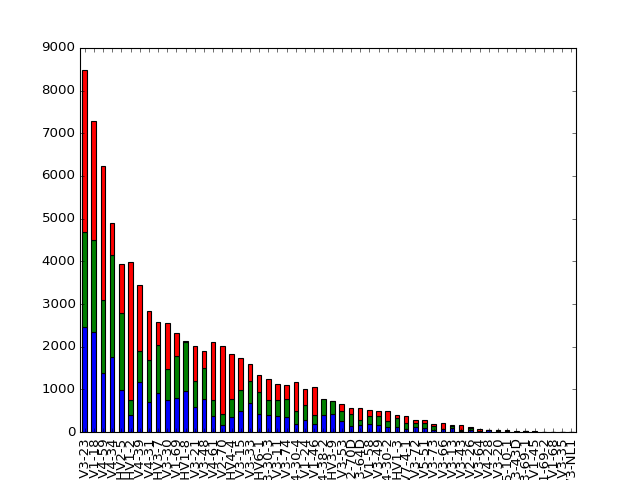

<IPython.core.display.Javascript object>


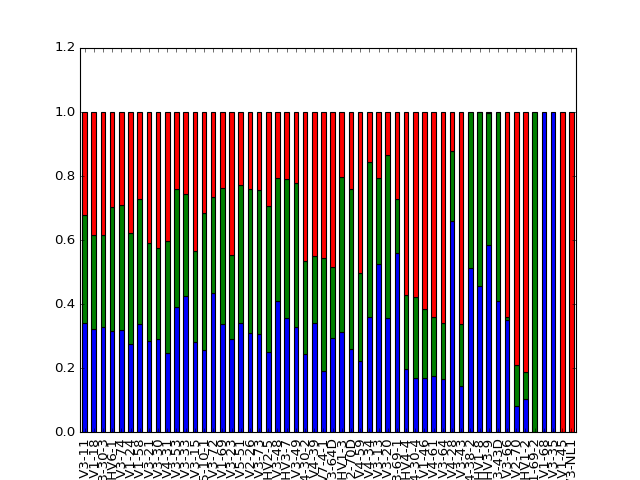

In [147]:
%matplotlib notebook

#
# Day 0: distribution of clonotypes between individuals
#

def v_d0_plots(summary_df, cell_type=[]):
    if cell_type and all((x in ["plasma", "MBC", "PBMCs"]) for x in cell_type): 
        summary_df = summary_df[summary_df["cell_type"].isin(cell_type)]
        
    # Calculate normalised abundance of V genes by patient at day 0
    v_d0 = summary_df.query("day == 0").groupby(["V-GENE", "patient_code"]).sum()["norm_factor"].unstack().fillna(0)
    # Convert to proportion of repertoire
    v_d0_prop = v_d0.apply(lambda x: x/np.sum(x), axis=0)

    # Order V genes by total proportion of repertoire represented and plot
    v_d0_total_prop_idx = v_d0_prop.sum(axis=1).sort_values(ascending=False).index
    v_d0.loc[v_d0_total_prop_idx, :].plot(kind="bar", stacked=True, legend=None)
    # Normalise by total proportion of repertoire represented and replot
    # v_d0.loc[v_d0_total_prop_idx, :].apply(lambda x: x/np.sum(x), axis=1).plot(kind="bar", stacked=True, legend=None)

    # Order V genes by coefficent of variation and plot
    v_d0_cv_idx = v_d0.apply(lambda x: np.std(x)/np.mean(x), axis=1).sort_values().index
    v_d0.loc[v_d0_cv_idx, :].apply(lambda x: x/np.sum(x), axis=1).plot(kind="bar", stacked=True, legend=None)

v_d0_plots(summary_df) 
# v_d0_plots(summary_df, cell_type=["plasma"]) 
# v_d0_plots(summary_df, cell_type=["MBC"]) 
# v_d0_plots(summary_df, cell_type=["PBMCs"]) 

In [143]:
        summary_df[summary_df["cell_type"].isin(["MBC"])]

,day,sample_num,Sequence number,Sequence ID,digest,Functionality,V-GENE and allele,V-REGION score,V-REGION identity %,V-REGION identity nt,...,Sequence,V-GENE,J-GENE,CDR3_len,clonotype,Tag Index,patient_code,cell_type,norm_factor,Ab.Name
3034,0,15,1,MS7_20154111081786920807__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV3-23*01 F, or Homsap IGHV3-23*04 F ...",926.0,96.95,191/197 nt,...,cctatgccatgagctgggtccgccaggctccagggaaggggctgga...,IGHV3-23,IGHJ4,19,IGHV3-23.IGHJ4.19,15,2207,MBC,1.143597,NaN
3035,0,15,2,MS7_20154111061204721962__0_0_0_0_1_0_0_0_0_0_...,IGHG1,productive,"Homsap IGHV5-51*01 F, or Homsap IGHV5-51*03 F",961.0,92.79,206/222 nt,...,aagggttctggattcagtttttccagttactggatcgcctgggtgc...,IGHV5-51,IGHJ5,13,IGHV5-51.IGHJ5.13,15,2207,MBC,1.143597,NaN
3036,0,15,3,MS7_2015411103573910113__0_0_0_0_0_0_0_0_0_0_0...,IGHM,productive,Homsap IGHV3-43*02 F,935.0,97.46,192/197 nt,...,attatgccatgcactgggtccgtcaacctccagggaagggtctgga...,IGHV3-43,IGHJ6,16,IGHV3-43.IGHJ6.16,15,2207,MBC,1.143597,NaN
3037,0,15,4,MS7_2015411104180184313__0_1_0_0_0_0_0_0_0_0_0...,IGHA2,productive,"Homsap IGHV3-74*01 F, or Homsap IGHV3-74*02 F",773.0,88.32,174/197 nt,...,gtcactggatgcactgggtccgccaagcgccagggaaggggctggt...,IGHV3-74,IGHJ4,10,IGHV3-74.IGHJ4.10,15,2207,MBC,1.143597,NaN
3038,0,15,5,MS7_2015411110131329123__0_0_0_0_1_0_0_0_0_0_0...,IGHG1,productive,"Homsap IGHV1-2*02 F, or Homsap IGHV1-2*05 F",726.0,86.53,167/193 nt,...,ttggatgcactgggtgcgacaggcccctggacaagggcttgagtgg...,IGHV1-2,IGHJ4,13,IGHV1-2.IGHJ4.13,15,2207,MBC,1.143597,NaN
3039,0,15,6,MS7_20154121021013617314__0_2_0_0_0_0_0_0_0_0_...,IGHA2,productive,Homsap IGHV2-5*02 F,1047.0,96.86,216/223 nt,...,cttctctgggttctcactcaccaccagaggaatgggtgtgggctgg...,IGHV2-5,IGHJ4,16,IGHV2-5.IGHJ4.16,15,2207,MBC,1.143597,NaN
3040,0,15,7,MS7_201541211892169406__1_0_0_0_0_0_0_0_0_0_0_...,IGHA1,productive,"Homsap IGHV3-21*01 F, or Homsap IGHV3-21*02 F",854.0,92.89,183/197 nt,...,gctatagcatgaattgggtccgccaggctccagggaaggggctgga...,IGHV3-21,IGHJ4,10,IGHV3-21.IGHJ4.10,15,2207,MBC,1.143597,NaN
3041,0,15,8,MS7_201541211996285495__0_0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV3-23*01 F, or Homsap IGHV3-23*04 F ...",980.0,100.00,197/197 nt,...,gctatgccatgagctgggtccgccaggctccagggaaggggctgga...,IGHV3-23,IGHJ4,12,IGHV3-23.IGHJ4.12,15,2207,MBC,1.143597,NaN
3042,0,15,9,MS7_20154111022561916692__0_0_0_0_0_0_0_0_0_0_...,IGHM,productive,"Homsap IGHV4-30-2*01 F, or Homsap IGHV4-30-2*0...",262.0,89.39,59/66 nt,...,tccaagaaccacttcgccctgaaactgaactctgtgacggccgcgg...,IGHV4-30-2,IGHJ3,19,IGHV4-30-2.IGHJ3.19,15,2207,MBC,1.143597,NaN
3043,0,15,10,MS7_20154111111609415422__0_1_0_0_0_0_0_0_0_0_...,IGHA2,productive,"Homsap IGHV1-2*02 F, or Homsap IGHV1-2*05 F",816.0,91.71,177/193 nt,...,ctatatgcactgggtgcgacaggcccctggacaaggacttgaatgg...,IGHV1-2,IGHJ4,14,IGHV1-2.IGHJ4.14,15,2207,MBC,1.143597,NaN
